In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer
from data_pipelines.data_manipulation import DataManipulation
from dl_models.xgboost_forecaster import XgboostForecaster
from logger.logger import Logger


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [2]:
SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [i for i in range(5,21)]
range_list = [i*scale for i in range_list]
interval = '1h'
start_date = '2020-06-30'
end_date = '2022-07-01'
source = 'yahoo'
LOG_PATH = '../logger' + os.sep + "logs"
LOG_FILE_NAME_PREFIX = f"log_{SYMBOL_CUT}_{start_date}_{end_date}"

logger = Logger(LOG_PATH, LOG_FILE_NAME_PREFIX)
tsa = TweetSentimentAnalyzer()
data = DataManipulation(SYMBOL, source, range_list, start_date=start_date, 
                        end_date=end_date, interval=interval, scale=scale, 
                        prefix_path='..', saved_to_csv=True,
                        logger=logger)
df_price = data.df.copy()

1 ) 26-12-2022 22_23_46 MainThread INFO\ Initialized logging at path ../logger/logs/log_btc_2020-06-30_2022-07-01_26-12-2022_22_23_46.log
2 ) 26-12-2022 22_23_49 MainThread DEBUG\ Get data from local file ../data/outputs/data_ind/BTC-USD/BTC-USD_df_2020-06-30_2022-07-01_1h.csv


In [3]:
df_price_ext = data.extract_features()
close_col = df_price.loc['2021-01-01':'2022-06-27',['close','volume']].copy()

3 ) 26-12-2022 22_23_50 MainThread DEBUG\ Get features matrix from ../data/outputs/feature_data/BTC-USD BTC-USD_df_2020-06-30_2022-07-01_1h.csv


In [4]:
sent_tweets = pd.read_csv('btc_archieve/btc_hourly_sent_score.csv')
#sent_tweets = pd.read_csv('../data/tweets_data/btc/btc_hour.csv')
sent_tweets.Datetime = pd.to_datetime(sent_tweets.Datetime)
sent_tweets.set_index('Datetime', inplace=True, drop=True)

In [5]:
sent_tweets.index = sent_tweets.index.tz_convert(None)

In [6]:
df_price_ext.head()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,feature_label,kz_score
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-10 18:00:00,0,1,1,1,0,1,0,0,2,2,...,1,0,0,0,0,0,0,1,1.0000,1.6499
2020-06-10 19:00:00,0,1,1,1,1,1,0,0,3,2,...,0,0,0,0,0,0,1,1,1.0000,2.4858
2020-06-10 20:00:00,0,1,1,1,1,1,0,0,3,2,...,0,0,0,0,0,1,1,1,0.0000,2.5052
2020-06-10 21:00:00,0,1,1,1,1,1,0,0,3,2,...,0,0,0,0,1,1,1,1,1.0000,2.4896
2020-06-10 22:00:00,1,1,1,1,1,1,0,0,3,2,...,0,0,0,1,1,1,1,1,0.0000,2.5701


In [7]:
df_final = tsa.concat_ohlc_compound_score(df_price_ext, sent_tweets)
#df_final = df_final.loc['2021-01-01':,:].copy()
df_final.dropna(inplace=True)

Concantenation for sentiment score tweets and indicator MAtrix data


In [8]:
df_final.shape

(13043, 262)

Text(0.5, 1.0, 'Bitcoin Proce')

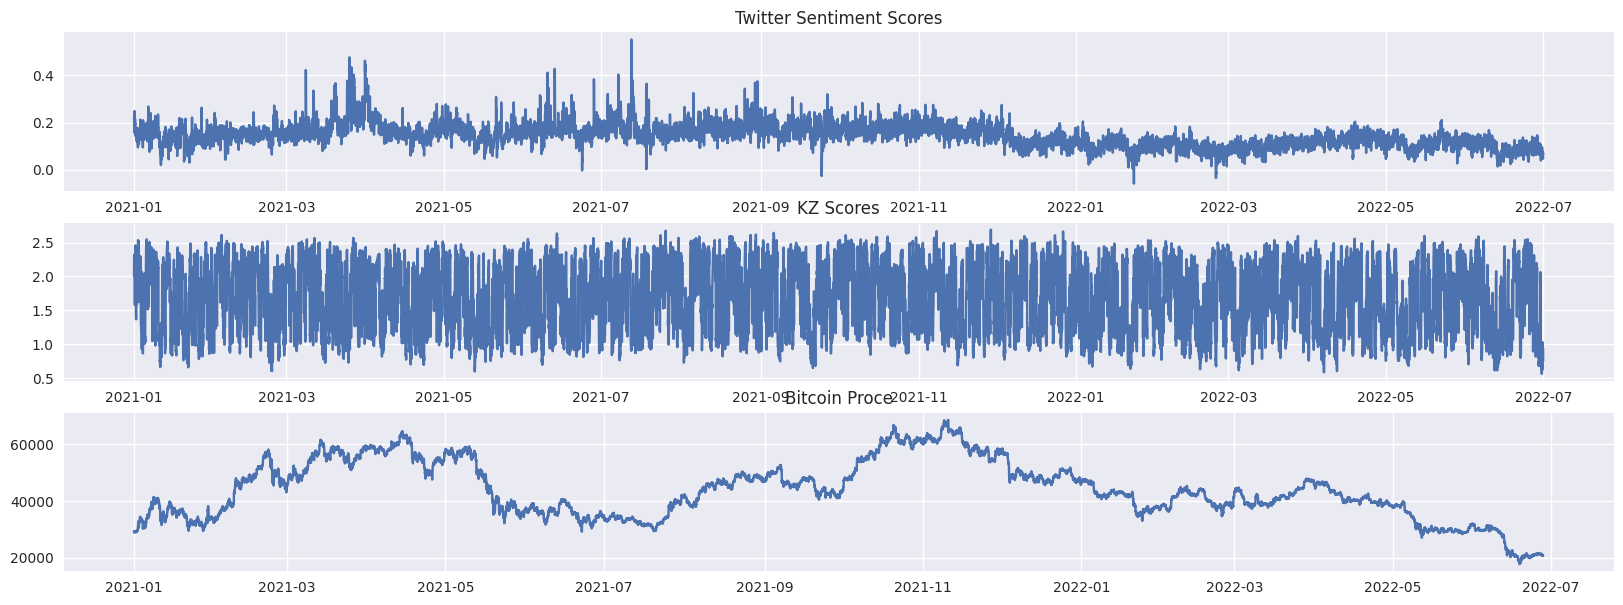

In [9]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(20,7))
ax1.plot(df_final.compound_total)
ax1.set_title('Twitter Sentiment Scores')
ax2.plot(df_final.index, df_final.kz_score)
ax2.set_title('KZ Scores')
ax3.plot(close_col.index, close_col.close)
ax3.set_title('Bitcoin Proce')

In [10]:
df = df_final.copy()
df.reset_index(drop=True, inplace=True)
df.head()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,feature_label,kz_score,compound_total
0,1,1,1,0,1,0,0,0,2,2,...,1,1,1,0,0,0,1,1.0000,2.0033,0.2208
1,1,1,1,1,1,1,0,0,2,2,...,1,1,0,0,0,1,0,0.0000,2.3200,0.1708
2,0,1,1,1,1,1,0,0,2,2,...,1,0,0,0,1,0,0,1.0000,2.2414,0.1684
3,0,1,1,1,1,1,0,0,2,2,...,0,0,0,1,0,0,0,0.0000,2.2773,0.1578
4,0,1,1,1,1,1,0,0,2,2,...,0,0,1,0,0,0,0,0.0000,2.2303,0.2447


In [19]:
y = df_final.feature_label
X = df_final.drop(columns=['feature_label'], axis=1)

Creating X_train, X_test, y_train, y_test, evalset
[0]	validation_0-logloss:0.68780	validation_1-logloss:0.69283
[1]	validation_0-logloss:0.68279	validation_1-logloss:0.69259
[2]	validation_0-logloss:0.67789	validation_1-logloss:0.69237
[3]	validation_0-logloss:0.67300	validation_1-logloss:0.69214
[4]	validation_0-logloss:0.66821	validation_1-logloss:0.69199
[5]	validation_0-logloss:0.66350	validation_1-logloss:0.69188
[6]	validation_0-logloss:0.65880	validation_1-logloss:0.69167
[7]	validation_0-logloss:0.65414	validation_1-logloss:0.69160
[8]	validation_0-logloss:0.64956	validation_1-logloss:0.69158
[9]	validation_0-logloss:0.64501	validation_1-logloss:0.69156
[10]	validation_0-logloss:0.64046	validation_1-logloss:0.69157
[11]	validation_0-logloss:0.63599	validation_1-logloss:0.69164
[12]	validation_0-logloss:0.63151	validation_1-logloss:0.69164
[13]	validation_0-logloss:0.62716	validation_1-logloss:0.69162
[14]	validation_0-logloss:0.62277	validation_1-logloss:0.69156
[15]	validatio

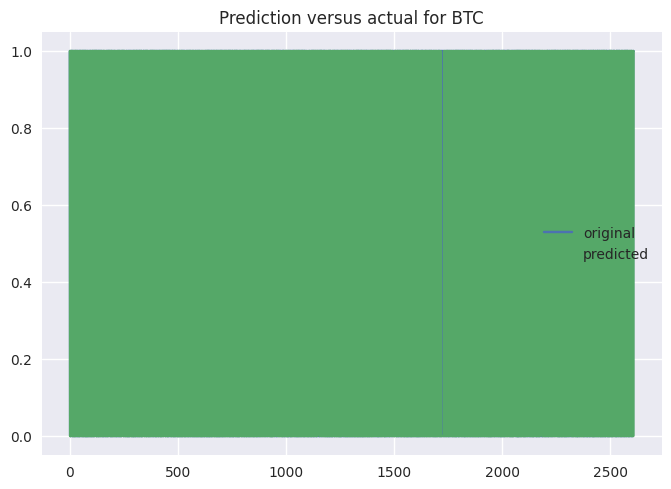

In [20]:
#y = (df_final.feature_label > 0).astype(int)                            #df_final.feature_label
#df_final.drop(columns=['feature_label'], axis=1)
from sklearn.metrics import accuracy_score, confusion_matrix

eval_metric = 'logloss'
eval_metric = None
xgb = XgboostForecaster(objective='binary', n_estimators=100, eta=0.01, max_depth=20, 
                    tree_method='gpu_hist', eval_metric='logloss')
xgb.create_train_test_data(X, y, test_size=0.2)
xgb.fit()
xgb.save_model(f'../dl_models/model_stack/model_price_{interval}_feature_numbers_{X.shape[1]}.json')
score = xgb.get_score()
print(f'first score: {score}')
#xgb.plot_learning_curves()
xgb.get_model_names('../dl_models/model_stack/')
#best_params = xgb.bestparams_gridcv([100, 200], [0.1], [1, 3], verbose=3)

ytest = xgb.y_test
ypred_reg = xgb.model.predict(xgb.X_test)
#print(f'Last accuracy: {accuracy_score(ytest, ypred_reg)}')
#print(f'Confusion Matrix: {confusion_matrix(ytest, ypred_reg)}')
x_ax = range(len(xgb.y_test))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred_reg, label="predicted")
plt.title("Prediction versus actual for BTC")
plt.legend()
plt.show()
#yhat = (xgb.model.predict(xgb.X_test) > 0).astype(int)
#y_ = (xgb.y_test > 0).astype(int)
#accuracy = accuracy_score(yhat, y_)
#print('Accuracy: %.3f' % accuracy)

{'st_kama_8': 0.05554913, 'lag_3': 0.012934106, 'st_cut_wma_5_6': 0.012583627, 'st_tema_7': 0.010639276, 'st_kama_7': 0.009069478, 'st_sma_19': 0.008376952, 'st_tema_20': 0.007245056, 'st_sma_20': 0.006907056, 'st_cut_ema_15_16': 0.006801677, 'st_adxdmi_18': 0.00663853}


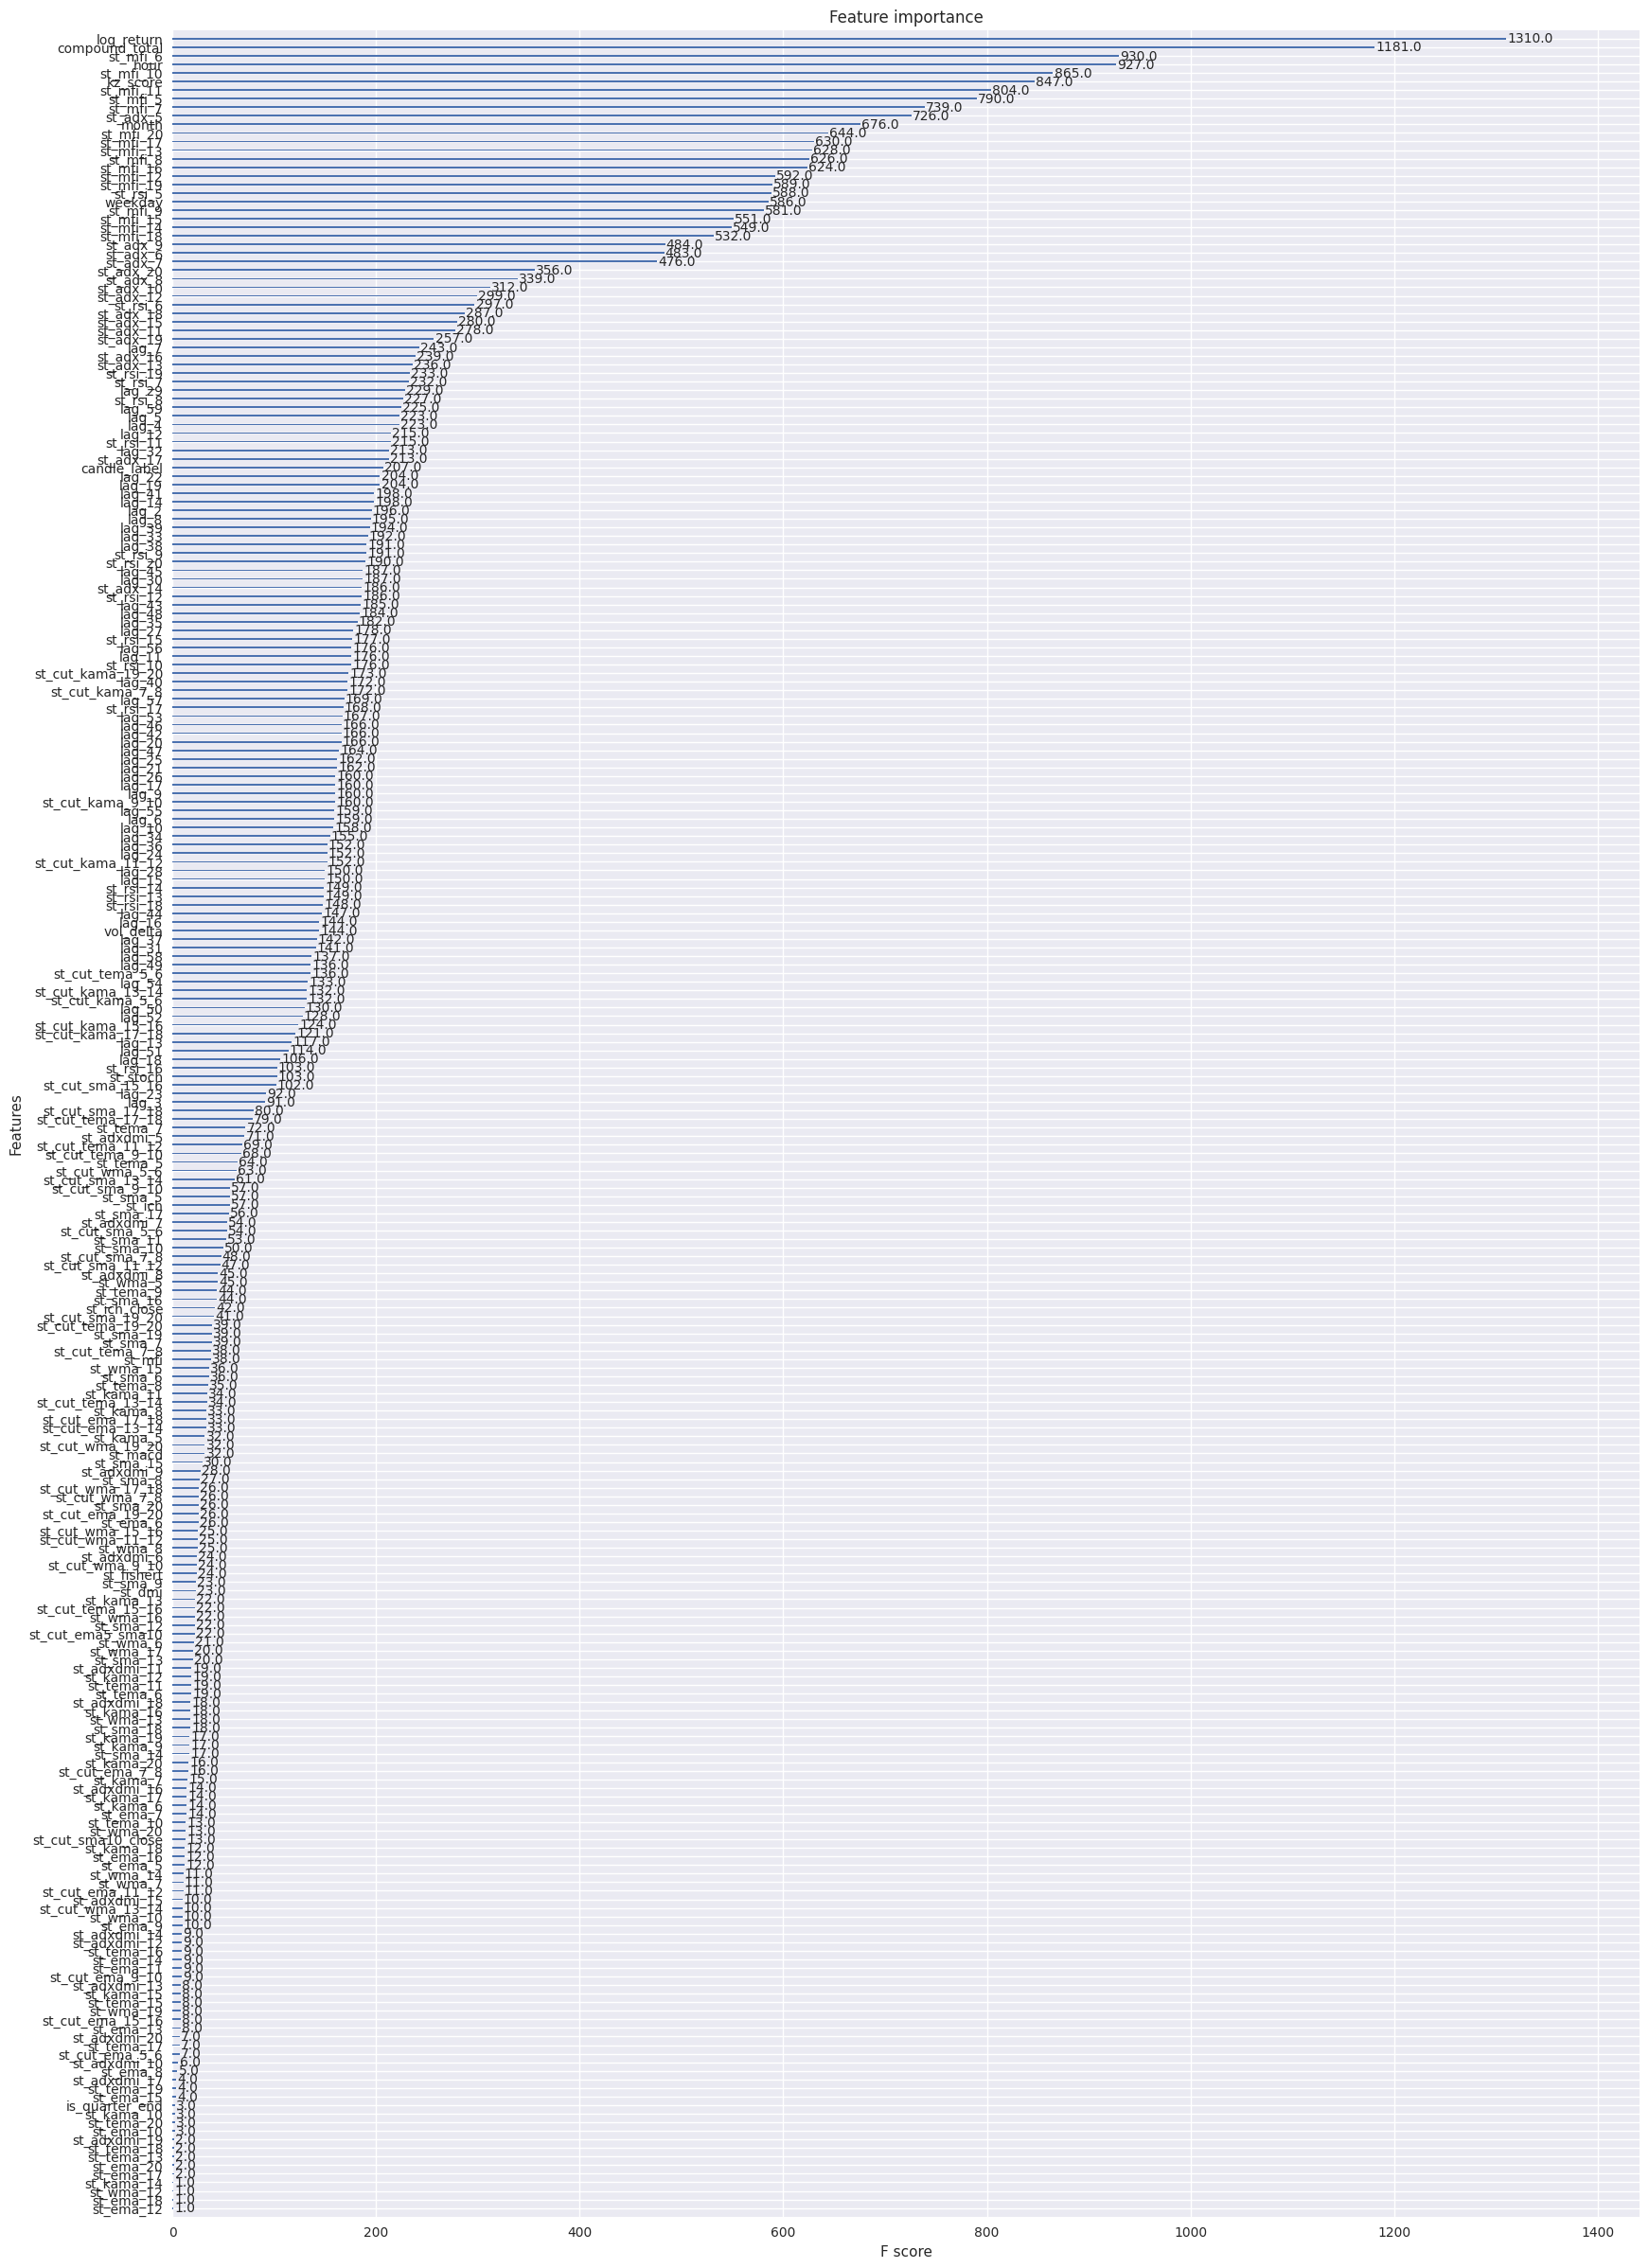

In [21]:
n_feat = xgb.get_n_importance_features(10)
print(n_feat)

xgb.plot_fature_importance()

Learning curves ploting and saved


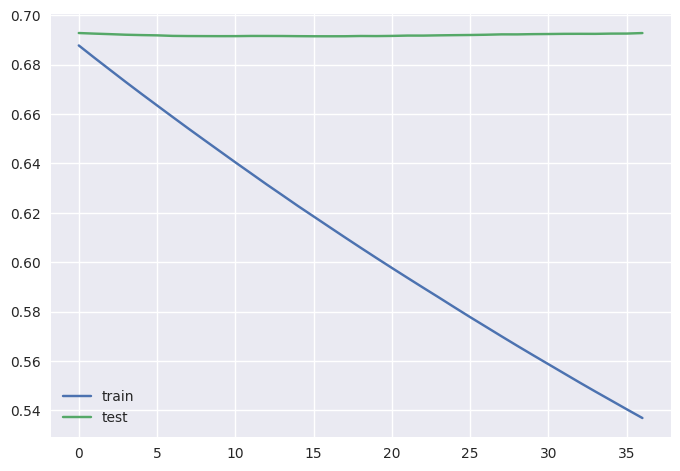

In [22]:
xgb.plot_learning_curves()